In [ ]:
from google.colab import drive #Importar la base de datos desde el drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 8.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import statistics
import pydot
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import pandas as pd
import cv2

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
!unzip /content/gdrive/MyDrive/TRABAJOGRADO/TRABAJO/Database3.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: Database3/Train/nv/ISIC_0026937.jpg  
  inflating: Database3/Train/nv/ISIC_0026939.jpg  
  inflating: Database3/Train/nv/ISIC_0026942.jpg  
  inflating: Database3/Train/nv/ISIC_0026943.jpg  
  inflating: Database3/Train/nv/ISIC_0026945.jpg  
  inflating: Database3/Train/nv/ISIC_0026946.jpg  
  inflating: Database3/Train/nv/ISIC_0026949.jpg  
  inflating: Database3/Train/nv/ISIC_0026971.jpg  
  inflating: Database3/Train/nv/ISIC_0026973.jpg  
  inflating: Database3/Train/nv/ISIC_0026974.jpg  
  inflating: Database3/Train/nv/ISIC_0026977.jpg  
  inflating: Database3/Train/nv/ISIC_0026979.jpg  
  inflating: Database3/Train/nv/ISIC_0026980.jpg  
  inflating: Database3/Train/nv/ISIC_0026982.jpg  
  inflating: Database3/Train/nv/ISIC_0026983.jpg  
  inflating: Database3/Train/nv/ISIC_0026985.jpg  
  inflating: Database3/Train/nv/ISIC_0026994.jpg  
  inflating: Database3/Train/nv/ISIC_0026997.jpg  
  inflating: Database

In [ ]:
def cargar_base_de_datos(ruta_directorio, image_size=(180, 180)):
    directorio_dataset = ruta_directorio

    imagenes = []
    etiquetas = []
    clases = {}

    for clase_id, clase in enumerate(os.listdir(directorio_dataset)):
        clase_path = os.path.join(directorio_dataset, clase)

        if not os.path.isdir(clase_path):
            continue

        clases[clase] = clase_id

        for archivo in os.listdir(clase_path):
            archivo_path = os.path.join(clase_path, archivo)

            img = cv2.imread(archivo_path)
            img = img.astype("float32") / 255.0
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            imagenes.append(img)
            etiquetas.append(clase_id)


    imagenes = np.array(imagenes)
    etiquetas = np.array(etiquetas)
    etiquetas_categoricas = to_categorical(etiquetas)
    return imagenes,etiquetas

In [ ]:
ruta1 = '/content/Database3/Train'
ruta2 = '/content/Database3/Train_val'
ruta3 = '/content/Database3/Test'

x_train, y_train = cargar_base_de_datos(ruta1, image_size=(180, 180))
x_val, y_val = cargar_base_de_datos(ruta2, image_size=(180, 180))
x_test, y_test = cargar_base_de_datos(ruta3, image_size=(180, 180))

In [ ]:
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5284, 180, 180, 3)
y_train shape: (5284,)
X_test shape: (1884, 180, 180, 3)
y_test shape: (1884,)


In [ ]:
def cargar_base_de_datos(ruta_directorio, image_size=(180, 180)):
    data = []
    labels = []
    class_names = os.listdir(ruta_directorio)

    for clase in class_names:
        class_path = os.path.join(ruta_directorio, clase)
        for file in os.listdir(class_path):
            image_path = os.path.join(class_path, file)

            # Lee la imagen con cv2
            img = cv2.imread(image_path)

            # Asegúrate de que la imagen se haya leído correctamente
            if img is not None:
                # Redimensiona la imagen
                img = cv2.resize(img, image_size)
                # Puedes realizar otros preprocesamientos aquí si es necesario

                # Agrega la imagen y la etiqueta a las listas
                data.append(img)
                labels.append(class_names.index(clase))  # Asigna un índice a cada clase

    return np.array(data), np.array(labels)

# Especifica la ruta del directorio que contiene las clases
ruta_directorio = '/content/Database3'
# Carga la base de datos
data, labels = cargar_base_de_datos(ruta_directorio)

In [ ]:
train_dataset = image_dataset_from_directory(
    'Database3/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int',
)
validation_dataset = image_dataset_from_directory(
    'Database3/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int',
)
test_dataset = image_dataset_from_directory(
    'Database3/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='int',
)

Found 5284 files belonging to 4 classes.
Found 2263 files belonging to 4 classes.
Found 1884 files belonging to 4 classes.


In [ ]:
def normalizar_imagenes(images, labels):
    images = images / 255.0  # Normalizar dividiendo por 255
    return images, labels

# Aplicar la función de normalización al dataset
test_dataset = test_dataset.map(normalizar_imagenes)
train_dataset = train_dataset.map(normalizar_imagenes)
validation_dataset = validation_dataset.map(normalizar_imagenes)

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def dataset_to_tuple(dataset):
    data_list = []
    for images, labels in dataset:
        for img, lbl in zip(images, labels):
            img_array = image.img_to_array(img)
            img_array = np.uint8(img_array)
            data_list.append((img_array, lbl.numpy()))
    return tuple(data_list)

In [ ]:
train_tuple = dataset_to_tuple(train_dataset)
test_tuple = dataset_to_tuple(test_dataset)
val_tuple = dataset_to_tuple(validation_dataset)

In [ ]:
x_train, y_train = zip(*train_tuple)
x_test, y_test = zip(*test_tuple)
x_val, y_val = zip(*val_tuple)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
print("Forma de x_train:", x_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_test:", y_test.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de y_val:", y_val.shape)

Forma de x_train: (5284, 180, 180, 3)
Forma de y_train: (5284,)
Forma de x_test: (1884, 180, 180, 3)
Forma de y_test: (1884,)
Forma de x_val: (2263, 180, 180, 3)
Forma de y_val: (2263,)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def create_encoder():
    conv_base  = keras.applications.efficientnet_v2.EfficientNetV2B0(
        weights="imagenet",
        include_top=False,
        input_shape=(180, 180, 3),
        pooling="avg"
    )

    conv_base.trainable = True
    for layer in conv_base.layers[:-4]:
        layer.trainable = False


    inputs = keras.Input(shape=(180, 180, 3))
    augmented = data_augmentation(inputs)
    outputs = conv_base(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 32
num_epochs = 100
temperature = 0.05

24274472/24274472 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       7         
                                                                 
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
Total params: 5919319 (22.58 MB)
Trainable params: 248320 (970.00 KB)
Non-trainable params: 5670999 (21.63 MB)
_________________________________________________________________


In [ ]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=(180, 180, 3))
    x = encoder(inputs)
    x = layers.Flatten()(x)
    x = layers.Dense(385, kernel_regularizer=regularizers.l1_l2(0.001), activation="elu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(4, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model



In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=(180, 180, 3))
    features = encoder(inputs)
    outputs = layers.Dense(128, activation="relu")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
from keras.callbacks import EarlyStopping
checkpoint_filepath = 'bestmodel.h5'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=10),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        verbose=1,
        min_lr=1e-12),

    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_sparse_categorical_accuracy',
        mode='max',
        save_best_only=True)
]

callbacks_list2 = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=8,
        verbose=1,
        min_lr=1e-12),
]

In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(x_train, y_train,
                                           batch_size=batch_size,
                                           epochs=100,
                                           verbose=1,
)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 1280)              5919319   
                                                                 
 dense_1 (Dense)             (None, 128)               163968    
                                                                 
Total params: 6083287 (23.21 MB)
Trainable params: 412288 (1.57 MB)
Non-trainable params: 5670999 (21.63 MB)
_________________________________________________________________
Epoch 1/100
166/166 [==============================] - 12s 23ms/step - loss: 3.4588
Epoch 2/100
166/166 [==============================] - 4s 23ms/step - loss: 3.4139
Epoch 3/100
166/166 [==============================] - 4s 23ms/step - loss: 3.4116
Epoch 4/100
166/166 [=========

In [ ]:
loss = history.history["loss"]
#val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

KeyError: ignored

In [ ]:
encoder.save("contrastive.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
train_dataset = image_dataset_from_directory(
    'Database3/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
validation_dataset = image_dataset_from_directory(
    'Database3/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)
test_dataset = image_dataset_from_directory(
    'Database3/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 5284 files belonging to 4 classes.
Found 2263 files belonging to 4 classes.
Found 1884 files belonging to 4 classes.


In [ ]:
def normalizar_imagenes(images, labels):
    images = images / 255.0  # Normalizar dividiendo por 255
    return images, labels

# Aplicar la función de normalización al dataset
test_dataset = test_dataset.map(normalizar_imagenes)
train_dataset = train_dataset.map(normalizar_imagenes)
validation_dataset = validation_dataset.map(normalizar_imagenes)

In [ ]:
classifier = create_classifier(encoder, trainable=False)
classifier.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 model_3 (Functional)        (None, 1280)              5919319   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 385)               493185    
                                                                 
 batch_normalization (Batch  (None, 385)               1540      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 385)               0         
                                                           

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit( x_train, y_train,
                          batch_size=batch_size,
                          epochs=num_epochs,
                          validation_data=(x_val, y_val),
                          verbose=1,
                          callbacks=callbacks_list
)


Epoch 1/100
166/166 [==============================] - 19s 59ms/step - loss: 8.1748 - sparse_categorical_accuracy: 0.6122 - val_loss: 2.9781 - val_sparse_categorical_accuracy: 0.7110 - lr: 0.0010
Epoch 2/100
166/166 [==============================] - 5s 32ms/step - loss: 2.3643 - sparse_categorical_accuracy: 0.6881 - val_loss: 1.7825 - val_sparse_categorical_accuracy: 0.7167 - lr: 0.0010
Epoch 3/100
166/166 [==============================] - 5s 32ms/step - loss: 1.6327 - sparse_categorical_accuracy: 0.7023 - val_loss: 1.3318 - val_sparse_categorical_accuracy: 0.7459 - lr: 0.0010
Epoch 4/100
166/166 [==============================] - 5s 30ms/step - loss: 1.3657 - sparse_categorical_accuracy: 0.7042 - val_loss: 1.3005 - val_sparse_categorical_accuracy: 0.6955 - lr: 0.0010
Epoch 5/100
166/166 [==============================] - 5s 30ms/step - loss: 1.2384 - sparse_categorical_accuracy: 0.7040 - val_loss: 1.1166 - val_sparse_categorical_accuracy: 0.7415 - lr: 0.0010
Epoch 6/100
166/166 [===

In [ ]:
print("--------------------------Test Results------------------------")
test_scores = classifier.evaluate(x_test, y_test, verbose=2)
print("Test Loss:", test_scores[0])
print("Test Accuracy:", test_scores[1])

--------------------------Test Results------------------------
59/59 - 1s - loss: 0.8590 - sparse_categorical_accuracy: 0.7404 - 1s/epoch - 24ms/step
Test Loss: 0.859049916267395
Test Accuracy: 0.7404458522796631


In [ ]:
classifier.save_weights('./checkpoints/my_checkpoint')

In [ ]:
classifier.save_weights(checkpoint_filepath.format(epoch=0))

In [ ]:
pip install pyyaml h5py

In [ ]:
classifier.save("Model.HDF5")

In [ ]:
classifier.save_weights("Model1.h5")

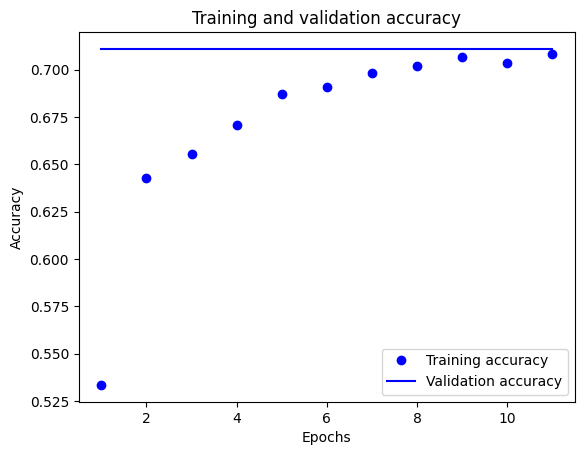

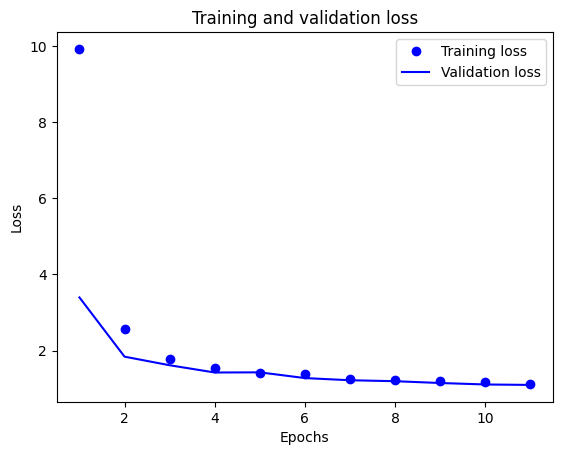

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
train_dataset = image_dataset_from_directory(
    'Database3/Train',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 5284 files belonging to 4 classes.


In [ ]:
predicciones_train = []  # store predicted labels
labels_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in train_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_train.append(label_batch)
   # compute predictions
   preds = classifier.predict(image_batch)
   # append predicted labels
   predicciones_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 28ms/step


In [ ]:
ultimo_label_train = labels_train.pop()
ultima_prediccion_train = predicciones_train.pop()

labels_train = np.array([np.argmax(i, axis = - 1) for i in labels_train]).flatten()
predicciones_train = np.array(predicciones_train).flatten()

ultimo_label_train = np.array([np.argmax(i, axis = - 1) for i in ultimo_label_train]).flatten()
labels_train = np.concatenate((labels_train, ultimo_label_train))
predicciones_train = np.concatenate((predicciones_train, ultima_prediccion_train))

In [ ]:
#predicciones_test = model.predict(images_test)
cf = metrics.confusion_matrix(labels_train,predicciones_train)
## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusion: Train')

## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
print(metrics.classification_report(labels_train,predicciones_train))

ValueError: ignored

In [ ]:
validation_dataset = image_dataset_from_directory(
    'Database3/Train_val',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 2263 files belonging to 4 classes.


In [ ]:
predicciones_val_train = []  # almacenar etiquetas predichas
labels_val_train = []  # almacenar etiquetas reales

# Iterar sobre el conjunto de validación
for image_batch, label_batch in zip(x_val, y_val):   # zip x_val e y_val
   # Añadir las etiquetas reales
   labels_val_train.append(label_batch)
   # Calcular las predicciones
   preds = classifier.predict(np.expand_dims(image_batch, axis=0))  # Asegurarse de que la entrada tenga la forma correcta
   # Añadir las etiquetas predichas
   predicciones_val_train.append(np.argmax(preds, axis=-1))

# Convertir las listas a arrays
labels_val_train = np.array([np.argmax(i, axis=-1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

# Crear la matriz de confusión y visualizarla
cf = metrics.confusion_matrix(labels_val_train, predicciones_val_train)

# Visualizar la matriz de confusión
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusión: Val')
plt.show()

# Mostrar el informe de clasificación
print(metrics.classification_report(labels_val_train, predicciones_val_train))

In [ ]:
predicciones_val_train = []  # store predicted labels
labels_val_train = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in validation_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_val_train.append(label_batch)
   # compute predictions
   preds = classifier.predict(image_batch)
   # append predicted labels
   predicciones_val_train.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 34ms/step


In [ ]:
ultimo_label_val_train = labels_val_train.pop()
ultima_prediccion_val_train = predicciones_val_train.pop()

labels_val_train = np.array([np.argmax(i, axis = - 1) for i in labels_val_train]).flatten()
predicciones_val_train = np.array(predicciones_val_train).flatten()

labels_val_train = np.concatenate((labels_val_train, np.argmax(ultimo_label_val_train, axis = - 1)))
predicciones_val_train = np.concatenate((predicciones_val_train, ultima_prediccion_val_train))

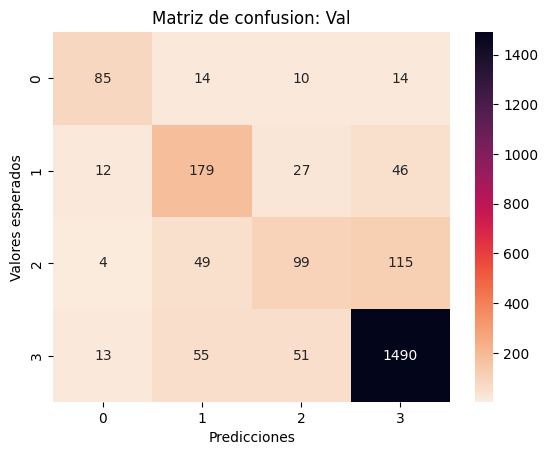

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       123
           1       0.60      0.68      0.64       264
           2       0.53      0.37      0.44       267
           3       0.89      0.93      0.91      1609

    accuracy                           0.82      2263
   macro avg       0.69      0.67      0.68      2263
weighted avg       0.81      0.82      0.81      2263



In [ ]:
#predicciones_test = model.predict(images_test)

cf = metrics.confusion_matrix(labels_val_train,predicciones_val_train)

## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusion: Val')
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_val_train,predicciones_val_train))

In [ ]:
test_dataset = image_dataset_from_directory(
    'Database3/Test',
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical',
)

Found 1884 files belonging to 4 classes.


In [ ]:
predicciones_test = []  # store predicted labels
labels_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_dataset:   # use dataset.unbatch() with repeat
   # append true labels
   labels_test.append(label_batch)
   # compute predictions
   preds = classifier.predict(image_batch)
   # append predicted labels
   predicciones_test.append(np.argmax(preds, axis = - 1))

1/1 [==============================] - 0s 31ms/step


In [ ]:
ultimo_label_test = labels_test.pop()
ultima_prediccion_test = predicciones_test.pop()

labels_test = np.array([np.argmax(i, axis = - 1) for i in labels_test]).flatten()
predicciones_test = np.array(predicciones_test).flatten()

labels_test = np.concatenate((labels_test, np.argmax(ultimo_label_test, axis = - 1)))
predicciones_test = np.concatenate((predicciones_test, ultima_prediccion_test))

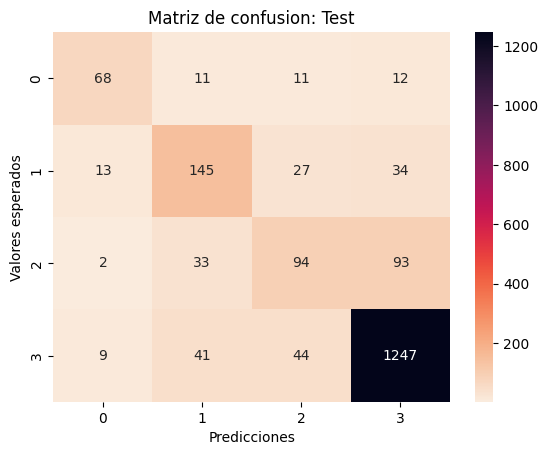

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       102
           1       0.63      0.66      0.65       219
           2       0.53      0.42      0.47       222
           3       0.90      0.93      0.91      1341

    accuracy                           0.82      1884
   macro avg       0.70      0.67      0.68      1884
weighted avg       0.82      0.82      0.82      1884



In [ ]:
cf = metrics.confusion_matrix(labels_test,predicciones_test)

## this command is only for google collab
## in the below figure " 1 is actually showing -1 and 0 is actually showing 1"
sns.heatmap(cf, annot=True, fmt="g", cmap=sns.color_palette("rocket_r",as_cmap=True))
plt.xlabel('Predicciones')
plt.ylabel('Valores esperados')
plt.title('Matriz de confusion: Test')
## It canbe used in any platform
# fig, ax = plot_confusion_matrix(conf_mat = cf, class_names = [1,-1])
plt.show()

print(metrics.classification_report(labels_test,predicciones_test))

In [ ]:
print(y_test)

[0 0 0 ... 3 3 3]


In [ ]:
test_dataset = tf.data.Dataset.zip((x_test, y_test))

# Ahora, puedes utilizar take en el conjunto de datos
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        results = classifier.predict(images)
        max_prob = max(results[i])
        class_ind = list(results[i]).index(max_prob)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Actual result: " + str(np.argmax(labels[i], axis=-1)) + "\n" + "Predicted result: " + class_names[class_ind])
        plt.axis("off")
plt.show()

TypeError: ignored

1/1 [==============================] - 0s 29ms/step
Actual Class: 1, Predicted Class: 1
1/1 [==============================] - 0s 29ms/step
Actual Class: 3, Predicted Class: 3
1/1 [==============================] - 0s 28ms/step
Actual Class: 3, Predicted Class: 3
1/1 [==============================] - 0s 29ms/step
Actual Class: 3, Predicted Class: 3
1/1 [==============================] - 0s 29ms/step
Actual Class: 3, Predicted Class: 3
1/1 [==============================] - 0s 28ms/step
Actual Class: 0, Predicted Class: 0
1/1 [==============================] - 0s 28ms/step
Actual Class: 0, Predicted Class: 3
1/1 [==============================] - 0s 28ms/step
Actual Class: 3, Predicted Class: 3
1/1 [==============================] - 0s 29ms/step
Actual Class: 3, Predicted Class: 3


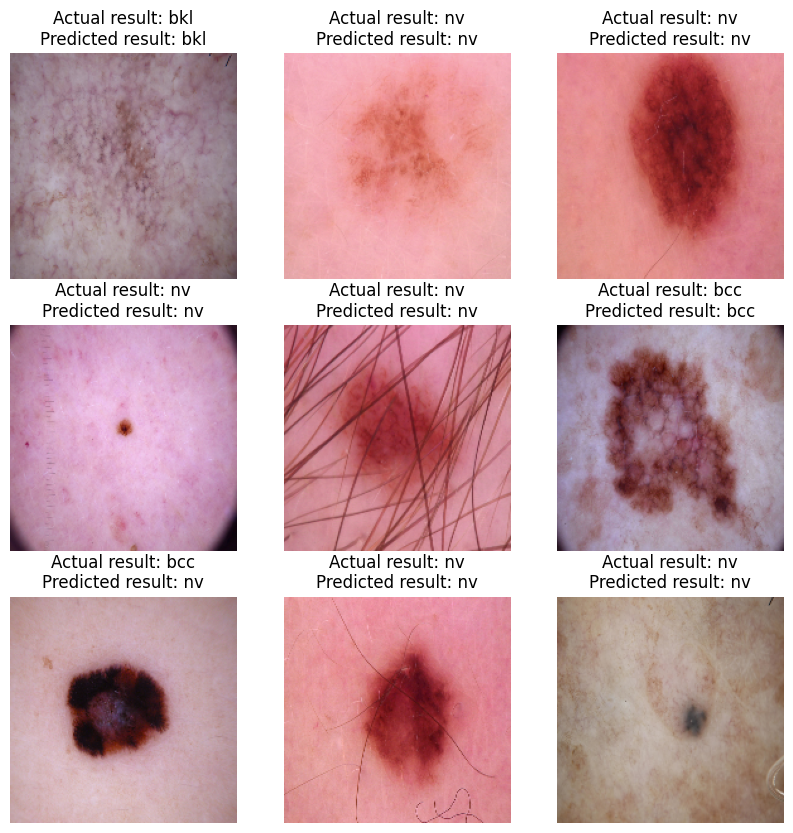

In [ ]:
plt.figure(figsize=(10, 10))
indices_aleatorios = np.random.choice(len(x_test), size=9, replace=False)

clases = {0: 'bcc', 1: 'bkl', 2: 'mel', 3: 'nv'}


for i, idx in enumerate(indices_aleatorios):
    ax = plt.subplot(3, 3, i + 1)

    results = classifier.predict(np.expand_dims(x_test[idx], axis=0))
    max_prob = max(results[0])
    class_ind = list(results[0]).index(max_prob)

    print(f"Actual Class: {y_test[idx]}, Predicted Class: {class_ind}")

    plt.imshow(x_test[idx].astype("float32"))
    plt.title("Actual result: " + clases[y_test[idx]] + "\n" + "Predicted result: " + clases[class_ind])
    plt.axis("off")

plt.show()

1/1 [==============================] - 0s 28ms/step
[[0.82554215 0.02380196 0.00461588 0.14603998]]
1/1 [==============================] - 0s 28ms/step
[[0.61949265 0.0964831  0.02752331 0.25650093]]
1/1 [==============================] - 0s 27ms/step
[[0.55973405 0.15634124 0.05832275 0.22560197]]
1/1 [==============================] - 0s 29ms/step
[[0.75877374 0.04683493 0.01150296 0.18288837]]
1/1 [==============================] - 0s 29ms/step
[[9.8855722e-01 2.8816089e-03 7.4348785e-04 7.8177815e-03]]
1/1 [==============================] - 0s 28ms/step
[[0.9685556  0.01313257 0.00471851 0.01359326]]
1/1 [==============================] - 0s 28ms/step
[[0.97445065 0.00654086 0.00286654 0.01614195]]
1/1 [==============================] - 0s 27ms/step
[[0.69985783 0.11994347 0.03578632 0.14441238]]
1/1 [==============================] - 0s 25ms/step
[[0.6906607  0.07067304 0.02563748 0.21302874]]


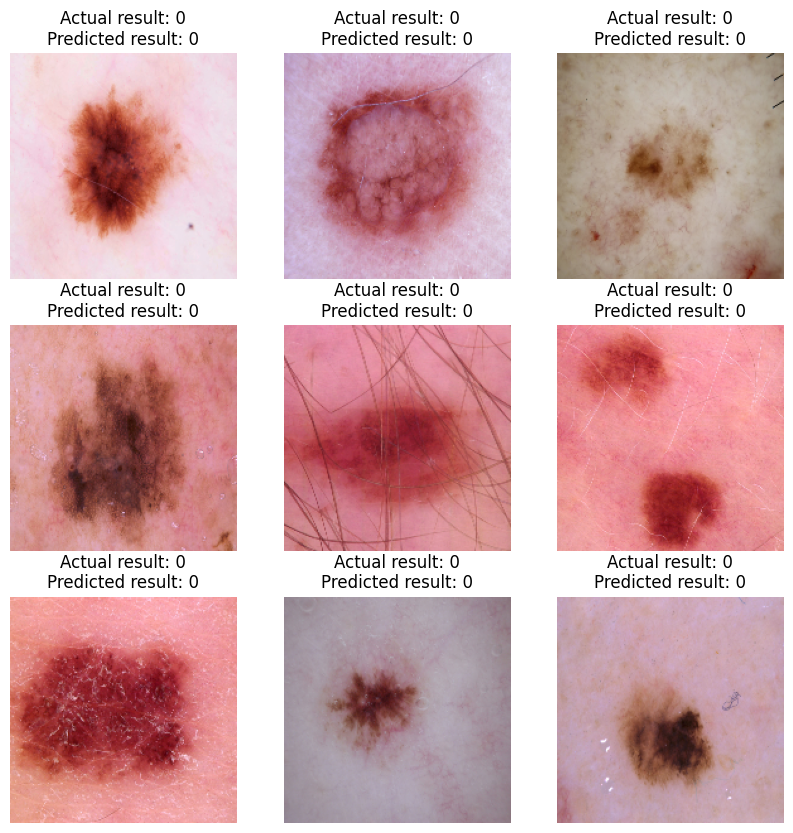

In [ ]:
#class_names = test_dataset.class_names
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # Obtener la predicción para la i-ésima imagen
    results = classifier.predict(np.expand_dims(x_test[i], axis=0))
    max_prob = max(results[0])
    class_ind = list(results[0]).index(max_prob)
    print(results)
    # Visualizar la imagen junto con la etiqueta
    plt.imshow(x_test[i].astype("float32"))
    plt.title("Actual result: " + str(np.argmax(y_test[i], axis=-1)) + "\n" + "Predicted result: " + str(class_ind))
    plt.axis("off")

plt.show()

In [ ]:
print(results)

[[0.6906607  0.07067304 0.02563748 0.21302874]]


[[[0.9098039  0.87941176 0.94411767]
  [0.904902   0.88284314 0.9490196 ]
  [0.9034314  0.879902   0.94754905]
  ...
  [0.87973857 0.8176471  0.9372549 ]
  [0.87009805 0.80735296 0.9269608 ]
  [0.878268   0.8153595  0.93741834]]

 [[0.89542484 0.87107843 0.94133985]
  [0.8985294  0.8745098  0.9401961 ]
  [0.90049016 0.87696075 0.9436274 ]
  ...
  [0.8833333  0.8269608  0.9267974 ]
  [0.879902   0.8215686  0.92647064]
  [0.8754902  0.8117647  0.93333334]]

 [[0.8964052  0.8753268  0.9401961 ]
  [0.9044118  0.87107843 0.9465686 ]
  [0.8993464  0.8743464  0.9478758 ]
  ...
  [0.88366014 0.83267975 0.9346405 ]
  [0.8784314  0.8186275  0.92990196]
  [0.87728757 0.820915   0.91944444]]

 ...

 [[0.90473855 0.86013067 0.9415032 ]
  [0.8897059  0.85       0.917647  ]
  [0.9001634  0.8609477  0.926634  ]
  ...
  [0.9057189  0.86650324 0.93022877]
  [0.8901961  0.8426471  0.92990196]
  [0.87973857 0.8393791  0.9289216 ]]

 [[0.8910131  0.855719   0.9272876 ]
  [0.9014706  0.8622549  0.9284314 ]


(-0.5, 179.5, 179.5, -0.5)

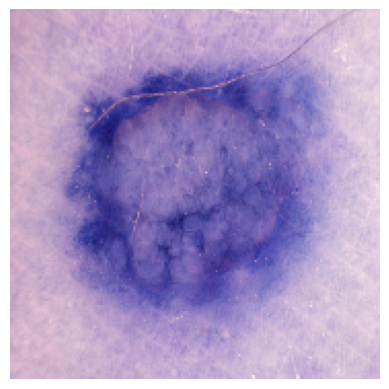

In [ ]:
print(x_test[0])
plt.imshow(x_test[i].astype("float"))
plt.axis("off")

In [ ]:
print(results)

[[3.75548936e-02 7.58272350e-01 8.84629786e-02 1.15709737e-01]
 [2.25083524e-04 1.91916450e-04 4.03112918e-03 9.95551765e-01]
 [7.74372165e-05 2.25294847e-02 8.59568417e-01 1.17824718e-01]
 [4.79556584e-05 6.17765996e-04 4.37734043e-03 9.94956911e-01]
 [4.27628402e-04 5.00765443e-03 1.41215855e-02 9.80443180e-01]
 [5.05567477e-05 9.06570535e-03 1.17384978e-02 9.79145169e-01]
 [4.92323995e-01 4.56325650e-01 2.78774509e-03 4.85625602e-02]
 [2.32645478e-02 1.02673657e-01 2.54311442e-01 6.19750321e-01]
 [1.92348042e-03 2.44716415e-03 1.55477598e-02 9.80081558e-01]
 [3.11711311e-01 5.42074032e-02 4.40280676e-01 1.93800598e-01]
 [2.52422108e-03 1.70247201e-02 1.12640269e-01 8.67810786e-01]
 [2.22376257e-04 1.31155094e-02 8.40790719e-02 9.02583063e-01]
 [1.08244654e-03 1.05749652e-01 1.12213358e-01 7.80954480e-01]
 [8.01710819e-04 1.45173654e-01 2.60439575e-01 5.93585074e-01]
 [1.49911270e-03 9.16591644e-01 2.76376270e-02 5.42716421e-02]
 [2.22406234e-05 4.28215275e-03 2.35893764e-02 9.721062

In [ ]:
import cv2
img = cv2.imread('/content/Database3/Test/bcc/ISIC_0031378.jpg')

In [ ]:
new_model = tf.keras.models.load_model('contrastive.h5')

In [ ]:
new_model = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
TFLITE_FILE_PATH = '/content/model_contrastive.tflite'
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)
my_signature = interpreter.get_signature_runner()


interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

NameError: ignored

In [ ]:
capas = classifier.layers
ultima_capa = capas[-1]
pesos_ultima_capa = ultima_capa.get_weights()
print(pesos_ultima_capa)

[array([[-0.05256953, -0.04584267, -0.05291305, -0.0342987 ],
       [ 0.04071597,  0.03845125,  0.03309432,  0.03323346],
       [ 0.01767638,  0.01406582,  0.01867527,  0.01510874],
       ...,
       [ 0.04439298,  0.04597962,  0.04860118,  0.0425832 ],
       [ 0.00979553,  0.00797343,  0.0093594 ,  0.01200734],
       [ 0.01993041,  0.0252512 ,  0.02234869,  0.02234036]],
      dtype=float32), array([-0.7792724 , -0.25846815, -0.32441425,  0.6563244 ], dtype=float32)]


In [ ]:
modelo = load_model('Modelofinal3.h5')

capas = modelo.layers
ultima_capa = capas[-1]
pesos_ultima_capa = ultima_capa.get_weights()

print(pesos_ultima_capa)

[array([[-0.05256953, -0.04584267, -0.05291305, -0.0342987 ],
       [ 0.04071597,  0.03845125,  0.03309432,  0.03323346],
       [ 0.01767638,  0.01406582,  0.01867527,  0.01510874],
       ...,
       [ 0.04439298,  0.04597962,  0.04860118,  0.0425832 ],
       [ 0.00979553,  0.00797343,  0.0093594 ,  0.01200734],
       [ 0.01993041,  0.0252512 ,  0.02234869,  0.02234036]],
      dtype=float32), array([-0.7792724 , -0.25846815, -0.32441425,  0.6563244 ], dtype=float32)]


In [ ]:
# Ruta del directorio que contiene las imágenes en formato JPG
directorio_jpg = '/content/Database3/Test/bcc'

# Ruta del directorio donde se guardarán las imágenes en formato PNG
directorio_png = '/content/Database3/Test/bcc2'

# Lista todos los archivos en el directorio JPG
archivos_jpg = os.listdir(directorio_jpg)

# Itera sobre cada archivo JPG
for archivo_jpg in archivos_jpg:
    # Construye la ruta completa del archivo JPG
    ruta_jpg = os.path.join(directorio_jpg, archivo_jpg)

    # Lee la imagen en formato JPG
    img = cv2.imread(ruta_jpg)

    # Construye la ruta completa del nuevo archivo PNG
    ruta_png = os.path.join(directorio_png, archivo_jpg.replace('.jpg', '.png'))

    # Guarda la imagen en formato PNG
    cv2.imwrite(ruta_png, img)



1/1 [==============================] - 0s 38ms/step
[[0.13374081 0.42757833 0.24862453 0.19005632]]
[1]


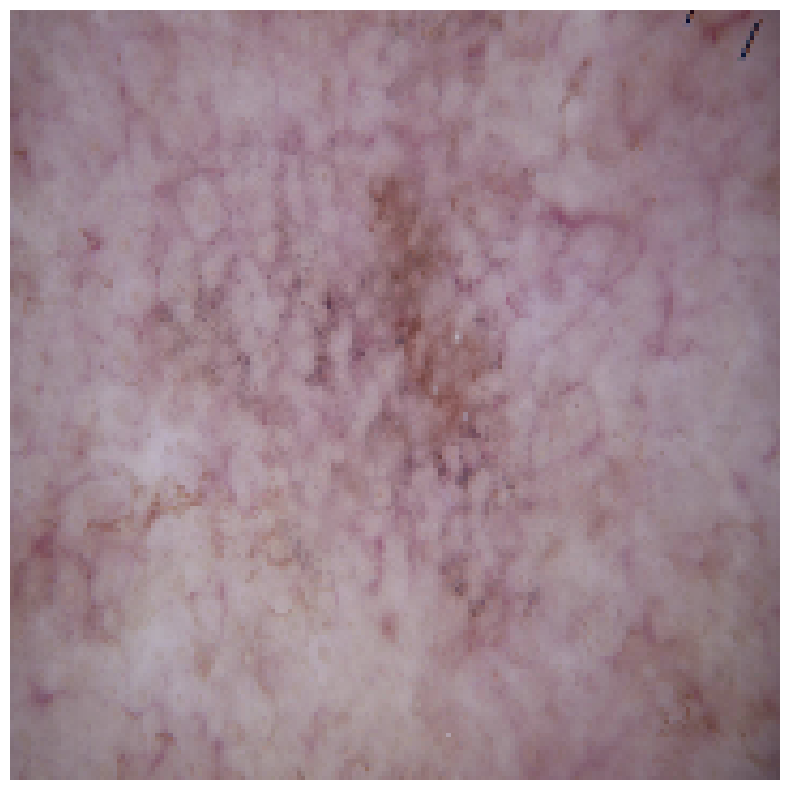

In [ ]:
import cv2
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model

#modelo = load_model('Modelofinal4.h5')

img = cv2.imread('/content/Database3/Test/bkl/ISIC_0026298.jpg')
img= cv2.resize(img,[180,180])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img.astype("float32") /255.0
#img = preprocess_input(img)

img = np.expand_dims(img, axis=0)
#img= np.reshape(img,[1,180,180,3])
img_batch = np.tile(img, (32, 1, 1, 1))


results1 = classifier.predict(img)

print(results1)
print(np.argmax(results1,axis=-1))

img = np.squeeze(img, axis=0)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
#print(class_names)
plt.show()

#plt.figure(figsize=(10, 10))
#ax = plt.subplot(3, 3, i + 1)
#plt.imshow(img.numpy().astype("uint8"))
#plt.title("Actual result: " + class_names[np.argmax(labels[i],axis=-1)] + "\n" + "Predicted result: " + class_names[np.argmax(class_name,axis=-1)])
#plt.axis("off")

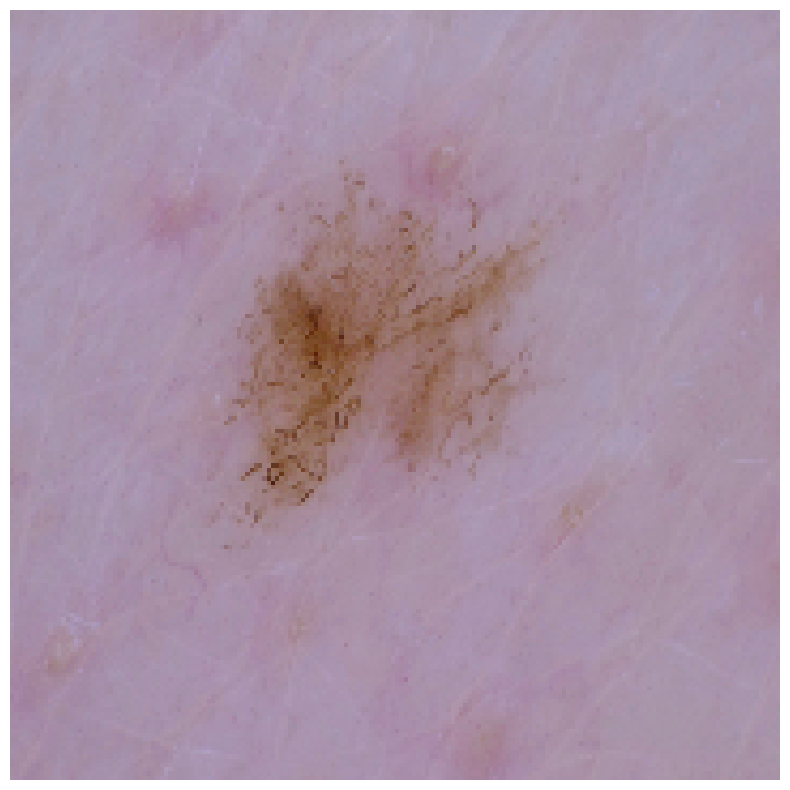

1/1 [==============================] - 2s 2s/step
[[0.06539042 0.1356077  0.134261   0.6647409 ]]
[3]


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

modelo = load_model('Modelofinal4.h5')

# Cargar la imagen con cv2
img_path = '/content/Database3/Test/bkl/ISIC_0024324.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (180, 180), interpolation=cv2.INTER_LINEAR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Cambiar el orden de los canales
img = img.astype("float32") / 255.0
img = preprocess_input(img)

# Expande las dimensiones para que coincidan con la forma esperada por el modelo
img = np.expand_dims(img, axis=0)

# Visualizar la imagen
plt.figure(figsize=(10, 10))
plt.imshow(img[0])  # Solo mostramos la primera imagen del batch
plt.axis("off")
plt.show()

# Realizar la predicción
results1 = modelo.predict(img)

print(results1)
print(np.argmax(results1, axis=-1))

In [ ]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.models import load_model

# Cargar la imagen con cv2
img_path = '/content/Database3/Test/bkl/ISIC_0024324.jpg'


plt.imshow(images[i].numpy().astype("uint8"))


#img = cv2.imread(img_path)
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.resize(img, (180, 180))

# Asegurarse de que la imagen se cargó correctamente
if img is not None:
    # Convertir la imagen a formato adecuado y preprocesarla
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Cargar el modelo
    modelo = load_model('Modelofinal2.h5')

    # Realizar la predicción
    results = modelo.predict(img_array)

    print(results)

1/1 [==============================] - 2s 2s/step
[[0.06505984 0.12558913 0.0853892  0.72396183]]


In [ ]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Cargar la imagen con cv2
img_path = '/content/Database3/Test/bkl/ISIC_0024324.jpg'
img = cv2.imread(img_path)
img = cv2.resize(img, (180, 180))

# Asegurarse de que la imagen se cargó correctamente
if img is not None:
    # Convertir la imagen a formato adecuado
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Cargar el modelo
    modelo = load_model('Modelofinal2.h5')

    # Realizar la predicción
    results = modelo.predict(img_array)

    # Imprimir las predicciones
    print("Predicciones:", results)

 # Suponiendo que classes es una lista de tus clases
classes = ['clase1', 'clase2', 'clase3', 'clase4']  # Reemplaza con tus clases reales

# Obtener el índice de la clase predicha
predicted_class_index = np.argmax(results)

# Obtener la etiqueta de la clase predicha
predicted_class = classes[predicted_class_index]

# Imprimir la clase predicha
print("Clase predicha:", predicted_class)

1/1 [==============================] - 2s 2s/step
Predicciones: [[0.05353173 0.10872069 0.09236877 0.7453788 ]]
Clase predicha: clase4


In [ ]:
print (results1)

[[0.05353173 0.10872069 0.09236877 0.7453788 ]]


In [ ]:
classifier.save("Modelofinal4.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_keras_model(classifier)
tflite_model = converter.convert()

In [ ]:
#tflite_models_dir = pathlib.Path("/tmp/mnist_tflite_models/")
tflite_models_dir = pathlib.Path(".")
tflite_model_file = tflite_models_dir/"model_contrastive.tflite"
tflite_model_file.write_bytes(tflite_model)

25401336

In [ ]:
!mkdir -p saved_model
classifier.save('saved_model/my_model')